# Show different masks (4 different methods)

In [1]:
import DeepFakeMask as dfm
import numpy as np
import matplotlib.pyplot as plt
import dlib
import utils as ut

In [2]:
img_path = "/Users/emrekavak/Documents/Ethical_AI/EAI_Data/CelebASample/"
srcp = "000001.jpg"
trgtp = "000002.jpg"

In [3]:
src_im = dlib.load_rgb_image(img_path+srcp)
trgt_im = dlib.load_rgb_image(img_path+trgtp)

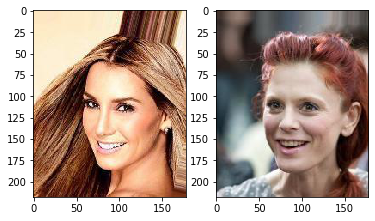

In [4]:
f, ax = plt.subplots(1,2)
ax[0].imshow(src_im)
ax[1].imshow(trgt_im)

In [5]:
src_im.shape

(218, 178, 3)

In [6]:
detector = dlib.get_frontal_face_detector()
trained_pred_path = "/Users/emrekavak/Documents/Ethical_AI/repo/proj-4/Face-X-Ray-master/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(trained_pred_path)

In [7]:
boxes = detector(src_im, 1)
box = boxes.pop()
landmarks = predictor(src_im, box)
landmarks_np = ut.shape_to_np(landmarks)

In [8]:
mask_dfl = dfm.dfl_full(landmarks=landmarks_np.astype('int32'),face=src_im, channels=3).mask/255
mask_components = dfm.components(landmarks=landmarks_np.astype('int32'),face=src_im, channels=3).mask/255
mask_extended = dfm.extended(landmarks=landmarks_np.astype('int32'),face=src_im, channels=3).mask/255
mask_facehull = dfm.facehull(landmarks=landmarks_np.astype('int32'),face=src_im, channels=3).mask/255

# Here they have 4 different versions to generate the mask

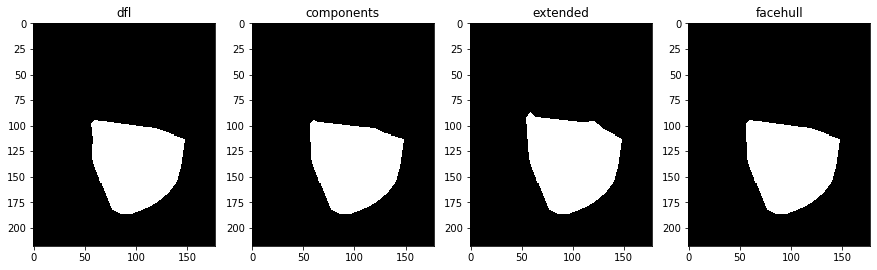

In [9]:
f, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(mask_dfl)
ax[1].imshow(mask_components)
ax[2].imshow(mask_extended)
ax[3].imshow(mask_facehull)

l = ["dfl", "components", "extended", "facehull"]

for i in range(len(l)):
    ax[i].set_title(l[i])

In [10]:
from skimage import transform as sktransform
import random
import cv2
from imgaug import augmenters as iaa
from skimage import io

/usr/local/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [11]:
import bi_online_generation as bi
distortion = iaa.Sequential([iaa.PiecewiseAffine(scale=(0.01, 0.15))])

# Further Processing
## 1) down-sample images and masks
## 2) take random type of blending mask
## 3) Deform the mask randomly
      3.1) PiecewiseAffine (as simple implementation)
      3.2) dilate or erode randomly
## 4) color transfer
## 5) resize back to default

In [19]:
# adapted from get_blended_face function
background_face = src_im
background_landmark = landmarks_np.copy()

foreground_face = trgt_im

# down sample before blending
aug_size_y = random.randint(190,218)
aug_size_x = random.randint(160,178)
background_landmark[:,0] = background_landmark[:,0] * (aug_size_x/178)
background_landmark[:,1] = background_landmark[:,1] * (aug_size_y/218)
foreground_face = sktransform.resize(foreground_face,(aug_size_y,aug_size_x),preserve_range=True).astype(np.uint8)
background_face = sktransform.resize(background_face,(aug_size_y,aug_size_x),preserve_range=True).astype(np.uint8)

# get random type of initial blending mask
mask_dfl = dfm.dfl_full(landmarks=background_landmark.astype('int32'),face=background_face, channels=3).mask/255
mask_components = dfm.components(landmarks=background_landmark.astype('int32'),face=background_face, channels=3).mask/255
mask_extended = dfm.extended(landmarks=background_landmark.astype('int32'),face=background_face, channels=3).mask/255
mask_facehull = dfm.facehull(landmarks=background_landmark.astype('int32'),face=background_face, channels=3).mask/255
masks = [mask_dfl, mask_components, mask_extended, mask_facehull]

#  random deform mask
for m in masks:
    m = distortion.augment_image(m)
    m = bi.random_erode_dilate(m)

# apply color transfer
foreground_faces = []
for m in masks:
    foreground_faces.append(bi.colorTransfer(background_face, foreground_face, m*255))

blended_faces = []
masks_ = []
# blend two face
for i in range(len(masks)):
    blended_face, mask = bi.blendImages(foreground_faces[i], background_face, masks[i]*255)
    blended_face = blended_face.astype(np.uint8)
    masks_.append(mask)
    blended_faces.append(blended_face)

blended_faces_resized = []
masks_resized = []
# resize back to default resolution
for f in blended_faces:
    blended_faces_resized.append(sktransform.resize(f,(218,178),preserve_range=True).astype(np.uint8))
for m in masks_:
    mask = sktransform.resize(m,(218,178),preserve_range=True)
    masks_resized.append(mask[:,:,0:1])

## Example 1:

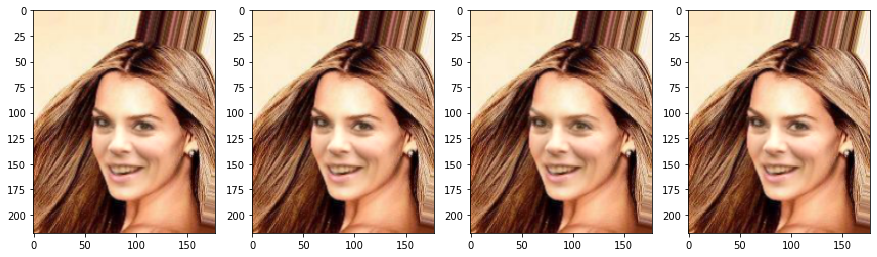

In [16]:
f, ax = plt.subplots(1,4, figsize=(15,15))

for i,f in enumerate(blended_faces_resized):
    ax[i].imshow(f)

## Rerun with different deformation

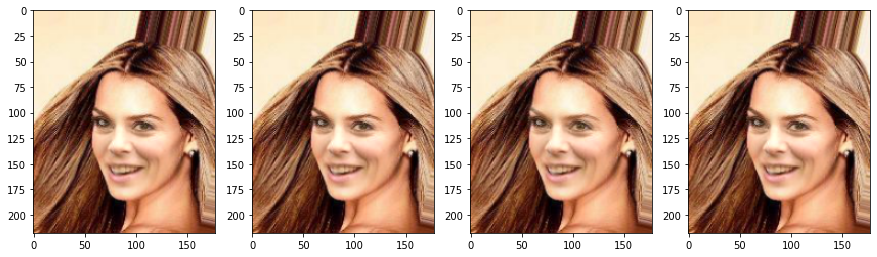

In [18]:
f, ax = plt.subplots(1,4, figsize=(15,15))

for i,f in enumerate(blended_faces_resized):
    ax[i].imshow(f)

## Different deformaton

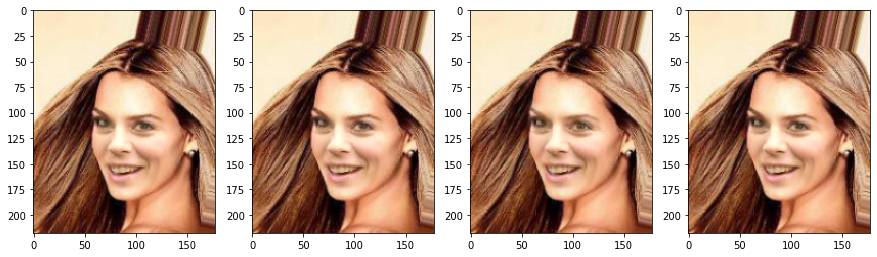

In [20]:
f, ax = plt.subplots(1,4, figsize=(15,15))

for i,f in enumerate(blended_faces_resized):
    ax[i].imshow(f)

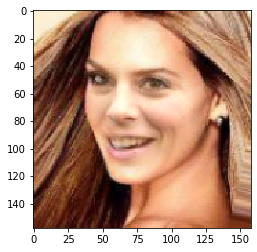

In [20]:
plt.imshow(blended_faces_resized[0][60:,20:])

# random post-processign after blending: 
# 1) downsample and upsample again 
# 2) img compression
# They do it to both the generated fakes and the original data

In [21]:
im1 = blended_faces_resized[0]

In [22]:
from PIL import Image

(178, 218)


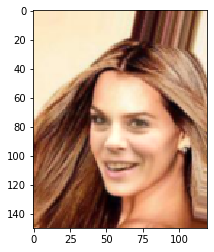

In [39]:
face_img = Image.fromarray(im1)

original_shape = im1.shape[:2][::-1]
print(original_shape)
aug_size = (150, 120)

if random.randint(0,1):
    face_img = face_img.resize(aug_size[::-1], Image.BILINEAR)
else:
    face_img = face_img.resize(aug_size[::-1], Image.NEAREST)
plt.imshow(face_img)
face_img = face_img.resize(original_shape,Image.BILINEAR)
face_img = np.array(face_img)

# random jpeg compression after BI pipeline

quality = random.randint(60, 100)
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
face_img_encode = cv2.imencode('.jpg', face_img, encode_param)[1]
face_img = cv2.imdecode(face_img_encode, cv2.IMREAD_COLOR)

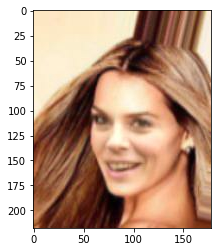

In [30]:
plt.imshow(face_img)

In [26]:
m = masks_resized[0]

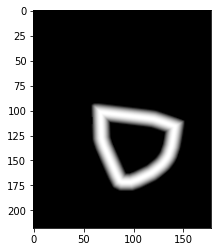

In [27]:
plt.imshow((4*m*(1-m))[:,:,0],cmap="gray")

In [104]:
import os

In [106]:
l = os.listdir("/Users/emrekavak/Desktop/c23/images")

In [107]:
l

['620_0625.png',
 '568_0005.png',
 '630_0256.png',
 '851_0260.png',
 '345_0349.png',
 '208_0111.png',
 '507_0037.png',
 '968_0297.png',
 '868_0199.png',
 '656_0432.png',
 '382_0012.png',
 '090_0164.png',
 '144_0075.png',
 '489_0472.png',
 '474_0118.png',
 '245_0251.png',
 '562_0358.png',
 '396_0127.png',
 '376_0514.png',
 '349_0461.png',
 '598_0284.png',
 '576_0319.png',
 '086_0176.png',
 '132_0316.png',
 '625_0029.png',
 '819_0076.png',
 '930_0419.png',
 '854_0108.png',
 '419_0227.png',
 '480_0152.png',
 '937_0119.png',
 '962_0242.png',
 '855_0135.png',
 '668_0368.png',
 '147_0351.png',
 '914_0069.png',
 '782_0495.png',
 '878_0306.png',
 '912_0568.png',
 '174_0108.png',
 '192_0199.png',
 '102_0109.png',
 '864_0115.png',
 '317_0102.png',
 '000_0297.png',
 '779_0159.png',
 '091_0011.png',
 '869_0211.png',
 '678_0280.png',
 '982_0513.png',
 '848_0291.png',
 '466_0288.png',
 '252_0322.png',
 '423_0563.png',
 '958_0261.png',
 '909_0483.png',
 '835_0132.png',
 '475_0333.png',
 '826_0076.png

# Just to see how the PieceWiseAffine Transform looks like

In [17]:
distortion = iaa.Sequential([iaa.PiecewiseAffine(scale=(0.01, 0.05))])

## Original

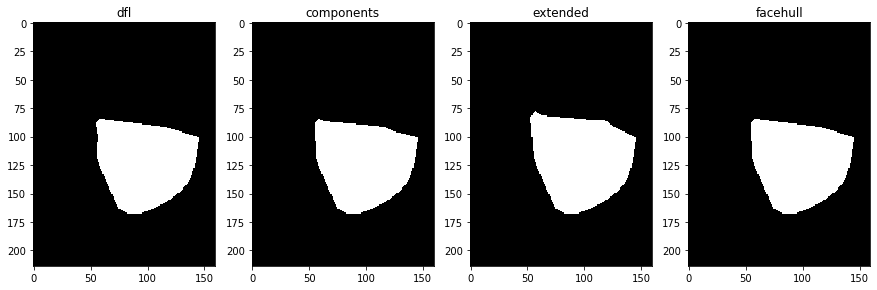

In [14]:
f, ax = plt.subplots(1,4, figsize=(15,15))
for i in range(len(masks)):
    ax[i].imshow(masks[i])

l = ["dfl", "components", "extended", "facehull"]

for i in range(len(l)):
    ax[i].set_title(l[i])

## Tranformed

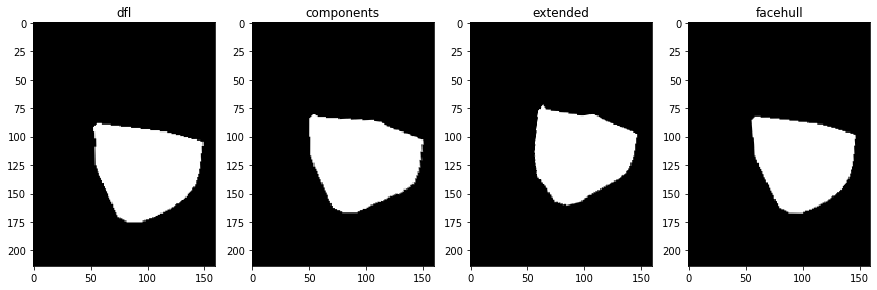

In [22]:
f, ax = plt.subplots(1,4, figsize=(15,15))
for i in range(len(masks)):
    ax[i].imshow(distortion.augment_image(masks[i]))

l = ["dfl", "components", "extended", "facehull"]

for i in range(len(l)):
    ax[i].set_title(l[i])

## Testing axes etc.:

In [68]:
# adapted from get_blended_face function
background_face = src_im
background_landmark = landmarks_np.copy()

foreground_face = trgt_im

# down sample on the same scale in each dimension
aug_size_y = int(0.6*218)
aug_size_x = int(0.8*178)
background_landmark[:,0] = background_landmark[:,0] * (aug_size_x/178)
background_landmark[:,1] = background_landmark[:,1] * (aug_size_y/218)
foreground_face = sktransform.resize(foreground_face,(aug_size_y,aug_size_x),preserve_range=True).astype(np.uint8)
background_face = sktransform.resize(background_face,(aug_size_y,aug_size_x),preserve_range=True).astype(np.uint8)

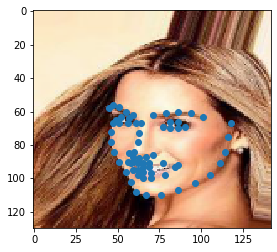

In [69]:
plt.imshow(background_face)
plt.scatter(background_landmark[:,0], background_landmark[:,1])

In [65]:
type(background_face)

numpy.ndarray

In [70]:
from skimage import io

In [71]:
im_new = io.imread(img_path+srcp)

In [72]:
im_new.shape

(218, 178, 3)

In [73]:
from PIL import Image

In [74]:
im = Image.fromarray(im_new)

In [77]:
im.save("/Users/emrekavak/Desktop/DataSet/asdf.jpeg")